In [1]:
import patsy as pa
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np

tfd = tfp.distributions

from MakeMyPrior.elicitation_wrapper import expert_model
from MakeMyPrior.training import trainer
from MakeMyPrior.helper_functions import group_obs, Exponential_unconstrained, Normal_unconstrained
from MakeMyPrior.user_config import target_config, target_input
from MakeMyPrior.discrepancy_measures import energy_loss
from MakeMyPrior.helper_functions import print_restab, plot_priors_hyp, plot_expert_preds, group_stats
import MakeMyPrior.combine_losses 

from tabulate import tabulate
import pprint
pp = pprint.PrettyPrinter(depth=4)

tf.random.set_seed(2024)

C:\Users\flobo\anaconda3\envs\make-my-prior\Lib\site-packages\bayesflow\trainers.py:27: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


## Method: Hyperparameter Learning
[//]: # (-.- .tabset)

### Method specification
+ PriorSamples($\lambda = (\mu_k, \sigma_k, \nu)$):
\begin{align*}
\{\beta_k\}_s &\sim \text{Normal}(\mu_k, \exp\{\sigma_k\})\\
\{s\}_s &\sim \text{Exponential}(\nu)
\end{align*}
+ Generator($\beta_k, s$):
\begin{align*}
\{\theta_i\}_s &= \{\beta_k\}_s \times X_i\\
\bar{s} &= \frac{1}{M} \sum_{i=1}^M \{s\}_s\\
\{y_i\}_s &\sim \text{Normal}(\{\theta_i\}_s, \bar{s})\\
\end{align*}
+ Targets($\{y_i\}_s$):
\begin{align*}
\{y_\text{rep}\}_s &= \{\sum_{a \in \text{EnC}}y_{i\in a}\}_s, \\
\{y_\text{shallow}\}_s &= \{\mathbb 1_{\text{new } \cap \text{ shallow}}\}_s, \\
\{\Delta_{eff}\}_s &= \{\bar{y}_{g1}\}_s - \{\bar{y}_{g2}\}_s \quad \text{ for } g1 = 3,4,5 \text{ and } g2 = 0,1,2\\
\{R^2\}_s &= \frac{Var(\{\theta_i\}_s)}{Var(\{y_i\}_s)} 
\end{align*}
+ Elicits($\{\bar{y}_{g}\}_s, \{\Delta_{eff}\}_s, \{R^2\}_s$)
\begin{align*}
\text{Quantile-based:} \quad &Q_p^{g} = Q_{p}^{g} \{y_i\}_s \quad \text{ for } g = 1,\ldots, 6, p = 0.1, \ldots, 0.9\\
\text{Quantile-based:} \quad &Q_p^{eff} = Q_{p}^{eff} \{\Delta_{eff}\}_s \quad \text{ for } eff = 1,2,3; p = 0.1, \ldots, 0.9\\
\text{Histogram-based:} \quad &\{R^2\}_s =\{R^2\}_s 
\end{align*}

### User specification

#### Setting hyperparameter for the learning algorithm

In [2]:
# -.-|m { input: true, output_error: false, input_fold: show }

# setting of hyperparameter of learning algorithm
user_config = dict(                    
        B = 2**8,                          
        rep = 300,                         
        epochs = 300,                      
        view_ep = 30,
        lr_decay = True,
        lr0 = 0.1, 
        lr_min = 0.0001, 
        loss_dimensions = "m,n:B",   
        loss_discrepancy = "energy", 
        loss_scaling = "unscaled",         
        method = "hyperparameter_learning"  
        )

### Define the design matrix

In [3]:
# construct design matrix
X =  pa.dmatrix("a*b", pa.balanced(a = 2, b = 3, repeat = 60), return_type="dataframe")
dmatrix = tf.cast(X, dtype = tf.float32)
# extract contrast matrix from design matrix (for allocating observations to groups)
cmatrix = dmatrix[0:dmatrix.shape[1], :]

print(X)

     Intercept  a[T.a2]  b[T.b2]  b[T.b3]  a[T.a2]:b[T.b2]  a[T.a2]:b[T.b3]
0          1.0      0.0      0.0      0.0              0.0              0.0
1          1.0      0.0      1.0      0.0              0.0              0.0
2          1.0      0.0      0.0      1.0              0.0              0.0
3          1.0      1.0      0.0      0.0              0.0              0.0
4          1.0      1.0      1.0      0.0              1.0              0.0
..         ...      ...      ...      ...              ...              ...
355        1.0      0.0      1.0      0.0              0.0              0.0
356        1.0      0.0      0.0      1.0              0.0              0.0
357        1.0      1.0      0.0      0.0              0.0              0.0
358        1.0      1.0      1.0      0.0              1.0              0.0
359        1.0      1.0      0.0      1.0              0.0              1.0

[360 rows x 6 columns]


### Setup the 'ideal agent'
Define an 'arbitrary' ground truth for the hyperparameter values for method validation.

In [4]:
# true hyperparameter values for ideal_expert
true_values = dict()
true_values["mu"] = [0.12, 0.15, -0.02, -0.03, -0.02, -0.04]
true_values["sigma"] = [0.02, 0.02, 0.06, 0.06, 0.03, 0.03]
true_values["nu"] = 9.

# model parameters
parameters_dict = dict()
for i in range(6):
    parameters_dict[f"beta_{i}"] = {
            "family":  Normal_unconstrained(),
            "true": tfd.Normal(true_values["mu"][i], true_values["sigma"][i]),
            "initialization": [tfd.Normal(0.,0.1)]*2
            }

exp_dist = Exponential_unconstrained(user_config["rep"])
parameters_dict["sigma"] = {
        "family": exp_dist,
        "true": exp_dist(tf.math.log(true_values["nu"])),
        "initialization": [tfd.Normal(0.,0.1)]
        }

print("True hyperparameter values:")
pp.pprint(true_values)

True hyperparameter values:
{'mu': [0.12, 0.15, -0.02, -0.03, -0.02, -0.04],
 'nu': 9.0,
 'sigma': [0.02, 0.02, 0.06, 0.06, 0.03, 0.03]}


### Define the data generating model

In [5]:
# -.-|m { input: true, output_error: false, input_fold: show }

# generative model
class GenerativeModel(tf.Module):
    def __call__(self, 
                 parameters, # obligatory: samples from prior distributions; tf.Tensor
                 dmatrix,    # optional: design matrix; tf.Tensor
                 cmatrix,    # optional: contrast matrix; tf.Tensor
                 **kwargs    # obligatory: possibility for further keyword arguments is needed 
                 ):  
        
        # compute linear predictor term
        epred = parameters[:,:,0:6] @ tf.transpose(dmatrix)
        
        # define likelihood
        likelihood = tfd.Normal(
            loc = epred, 
            scale = tf.expand_dims(parameters[:,:,-1], -1))
        
        # sample prior predictive data
        ypred = likelihood.sample()
        
        # compute custom target quantity (here: group-differences)
        samples_grouped = group_obs(ypred, dmatrix, cmatrix)

        # compute mean difference between groups
        effect_list = []
        diffs = [(3,0), (4,1), (5,2)]
        for i in range(len(diffs)):
            # compute group difference
            diff = tf.math.subtract(
                samples_grouped[:, :, :, diffs[i][0]],
                samples_grouped[:, :, :, diffs[i][1]]
            )
            # average over individual obs within each group
            diff_mean = tf.reduce_mean(diff, axis=2)
            # collect all mean group differences
            effect_list.append(diff_mean)

        mean_effects = tf.stack(effect_list, axis=-1)

        # compute marginals
        ## factor repetition: new, repeated
        marg_ReP = tf.reduce_mean(
            tf.stack([tf.math.add_n([samples_grouped[:, :, :, i] for i in j]) for j in [range(3),range(3,6)]], 
                     axis = -1), 
            axis = 2)
     
        ## factor Encoding depth: deep, standard, shallow
        marg_EnC = tf.reduce_mean(
            tf.stack([tf.math.add_n([samples_grouped[:, :, :, i] for i in j]) for j in [[0,3],[1,4],[2,5]]], 
                     axis = -1), 
            axis = 2)

        prob_y = tf.reduce_mean(samples_grouped, axis = 2)
        
        return dict(likelihood = likelihood,          # obligatory: likelihood; callable
                    ypred = ypred,                    # obligatory: prior predictive data
                    epred = epred,                    # obligatory: samples from linear predictor
                    mean_effects = mean_effects,      # optional: custom target quantity
                    marginal_ReP = marg_ReP,          # optional: custom target quantity
                    marginal_EnC = marg_EnC,           # optional: custom target quantity
                    weights = prob_y,
                    groups = samples_grouped
                    )

### Specify the target quantities and the elicitation technique

In [6]:
 # define a custom function using the output from the generative model   
def custom_r2(ypred, epred, **kwargs):
    return tf.math.divide(tf.math.reduce_variance(epred, axis = -1), 
                          tf.math.reduce_variance(ypred, axis = -1))

# specify target quantity, elicitation technique and loss combination
t1 = target_config(target = "marginal_ReP", 
                   elicitation = "quantiles", 
                   combine_loss = "by-group", 
                   quantiles_specs = (10, 20, 30, 40, 50, 60, 70, 80, 90))
t2 = target_config(target = "marginal_EnC", 
                    elicitation = "quantiles", 
                    combine_loss = "by-group", 
                    quantiles_specs = (10, 20, 30, 40, 50, 60, 70, 80, 90)) 
t3 = target_config(target = "mean_effects", 
                   elicitation = "quantiles",
                   combine_loss = "by-group",
                   quantiles_specs = (10, 20, 30, 40, 50, 60, 70, 80, 90))
t4 = target_config(target = "R2", 
                   elicitation = "histogram",
                   combine_loss = "all",
                   custom_target_function = custom_r2)

target_info = target_input(t1, t2, t3, t4)

pp.pprint(target_info)

{'combine_loss': ['by-group', 'by-group', 'by-group', 'all'],
 'custom_target_function': [None,
                            None,
                            None,
                            <function custom_r2 at 0x00000217B660C400>],
 'elicitation': ['quantiles', 'quantiles', 'quantiles', 'histogram'],
 'internal_loss': [None, None, None, None],
 'quantiles_specs': [(10, 20, 30, 40, 50, 60, 70, 80, 90),
                     (10, 20, 30, 40, 50, 60, 70, 80, 90),
                     (10, 20, 30, 40, 50, 60, 70, 80, 90)],
 'target': ['marginal_ReP', 'marginal_EnC', 'mean_effects', 'R2']}


## Expert model

In [10]:
expert_res_list, prior_pred_res = expert_model(1, user_config["rep"],
                                   parameters_dict, GenerativeModel, target_info,
                                   method = "ideal_expert",
                                   dmatrix = dmatrix,
                                   cmatrix = cmatrix,
                                   dmatrix_fct = dmatrix)

# elicited statistics from the (ideal) expert
expert_res_list.keys()

dict_keys(['marginal_ReP_quant_0', 'marginal_EnC_quant_1', 'mean_effects_quant_2', 'R2_hist_3'])

### Expert predictions

In [11]:
# group means
print(group_stats(prior_pred_res["ypred"], num_groups = 6))
# mean effects
print("mean effects:")
print(np.round(tf.reduce_mean(prior_pred_res["mean_effects"],(0,1)),2))
# marginal distribution: Repetition
print("marginal ReP (new, repeated):")
print(np.round(tf.reduce_mean(prior_pred_res["marginal_ReP"],(0,1)),2))
# marginal distribution: Encoding depth
print("marginal EnC (deep, standard, shallow):")
print(np.round(tf.reduce_mean(prior_pred_res["marginal_EnC"],(0,1)),2))

+-------+------+------+
| group | mean | std  |
+-------+------+------+
|  gr_0 | 0.12 | 0.02 |
|  gr_1 | 0.1  | 0.06 |
|  gr_2 | 0.09 | 0.06 |
|  gr_3 | 0.27 | 0.03 |
|  gr_4 | 0.23 | 0.07 |
|  gr_5 | 0.2  | 0.07 |
+-------+------+------+
mean effects:
[0.15 0.13 0.11]
marginal ReP (new, repeated):
[0.31 0.7 ]
marginal EnC (deep, standard, shallow):
[0.39 0.33 0.28]


In [9]:
# plot expert predictions
#plot_expert_preds(expert_res_list)

## Learning Algorithm

In [12]:
res_dict = trainer(expert_res_list, user_config["B"], user_config["rep"],
                   parameters_dict, user_config["method"], GenerativeModel,
                   target_info, user_config, loss_balancing = True, save_vals = ["prior_preds"],
                   dmatrix = dmatrix, cmatrix = cmatrix, dmatrix_fct = dmatrix)

epoch_time: 766.558ms
Epoch: 0, loss: 1.46675, lr: 0.100000
epoch_time: 177.066ms
Epoch: 30, loss: 0.26738, lr: 0.053144
epoch_time: 165.767ms
Epoch: 60, loss: 0.07021, lr: 0.028243
epoch_time: 175.198ms
Epoch: 90, loss: 0.02391, lr: 0.015009
epoch_time: 159.181ms
Epoch: 120, loss: 0.07784, lr: 0.007977
epoch_time: 171.367ms
Epoch: 150, loss: 0.07544, lr: 0.004239
epoch_time: 163.880ms
Epoch: 180, loss: 0.05937, lr: 0.002253
epoch_time: 180.418ms
Epoch: 210, loss: 0.06969, lr: 0.001197
epoch_time: 167.223ms
Epoch: 240, loss: 0.05790, lr: 0.000636
epoch_time: 187.252ms
Epoch: 270, loss: 0.06569, lr: 0.000338


### Training results

#### Loss

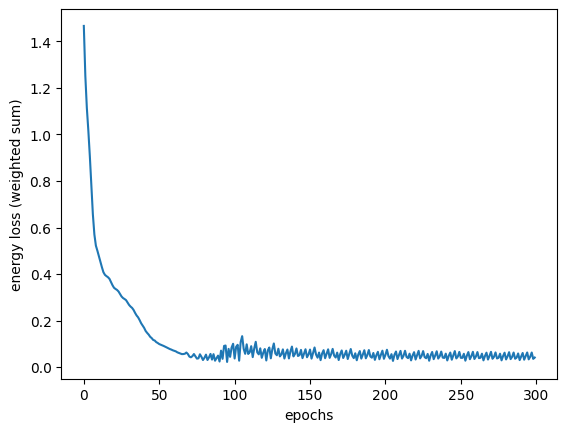

In [13]:
import matplotlib.pyplot as plt
import numpy as np

plt.plot(np.arange(len(res_dict["loss_info"])), res_dict["loss_info"]) 
plt.xlabel("epochs")
plt.ylabel("energy loss (weighted sum)")
plt.show()

#### Learned hyperparameter values

In [14]:
true_vals = [j for i in zip(true_values["mu"],true_values["sigma"]) for j in i]
true_vals += [true_values["nu"]]

tab, avg_res = print_restab(method = "hyperparameter_learning", 
                             num_vars = 13, 
                             res = res_dict["hyperparam_info"], 
                             start = 10, 
                             precision = 3, 
                             true_values = true_vals)
tab

var_name,pred mean,pred std,true,err
loc_0,0.133,0.011,0.12,0.013
scale_0,0.032,0.0,0.02,0.012
loc_1,0.141,0.012,0.15,0.009
scale_1,0.026,0.0,0.02,0.006
loc_2,-0.042,0.011,-0.02,0.022
scale_2,0.062,0.0,0.06,0.002
loc_3,-0.057,0.011,-0.03,0.027
scale_3,0.059,0.0,0.06,0.001
loc_4,-0.009,0.012,-0.02,0.011
scale_4,0.038,0.0,0.03,0.008


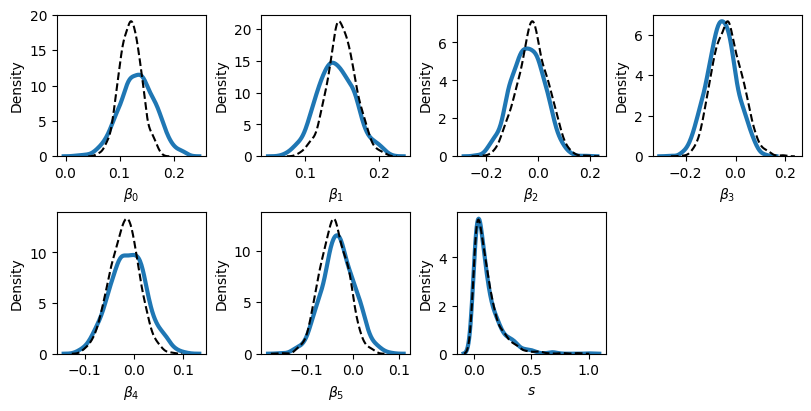

In [15]:
plot_priors_hyp(avg_res, true_values)